In [1]:
from baseline_cnn import *
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA NOT supported


## Load Train and Validation Data

In [4]:
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = loader('train.csv','./datasets/cs154-fa19-public/',transform=transform)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
# indices = list(range((int)(dataset_size/4))) # smmall part for experiments 
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## Load Test Data

In [5]:
test_transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])

testset = loader("test.csv", './datasets/cs154-fa19-public/', transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False)

## Show a sample from the dataset

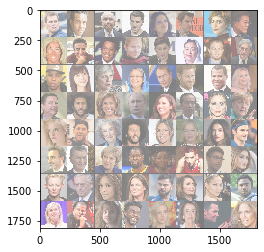

tensor([ 70, 138, 106, 182, 191, 182, 192, 121,  88,  54,  10, 176,  15, 133,
         76, 174, 114,  79, 151, 186, 135,  90,  32,  37,  27, 160,  28,  75,
         65, 112,  21, 118,  51, 143, 107, 160, 200, 166, 191,  29,  54, 128,
        151, 147,  19, 142, 179,  93, 110,   6, 169, 200,  62, 146, 164, 184,
         85,  10,  51,  36,  37, 146,  70, 164])


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next() # Batch_size is 4, so we get 4 images by calling next

# Places the images in a grid
imshow(torchvision.utils.make_grid(images))
print(labels)

## Create the network

In [7]:
net=Nnet().to(computing_device)
net.apply(weights_init)
print(net)

Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=1183, out_features=300, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=300, out_features=201, bias=True)
    (3): Softmax()
  )
)


## Define the Lossfunction and the Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005) # net.parameters is the weights of the network.


## Train the network

In [9]:
# Track the loss across training
train_epoch_losses = []
validation_epoch_losses = []
train_batch_losses = []
validation_batch_losses = []
avg_minibatch_loss = []
N = 3 # was 50
PATH = "./cnn_celeb.pth"  # Where to save the model

for epoch in range(N):
    N_minibatch_loss = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print("Mini_batch:", minibatch_count)
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)

        # labels= func.one_hot(labels, num_classes=201).type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()
        # Add this iteration's loss to the total_loss
        train_batch_losses.append(loss.item())
        N_minibatch_loss += loss

        if minibatch_count % N == 49:
            # Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
    print("Saving model...")
    torch.save(net.state_dict(), PATH)

    # save train loss
    train_epoch_loss = np.average(np.array(train_batch_losses))
    train_batch_losses = []
    train_epoch_losses.append(train_epoch_loss)

    with torch.no_grad():
        # validation implementation
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            # Put the validation minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)
            # Perform the forward pass through the network and compute the loss
            outputs = net(images)

            validation_batch_loss = criterion(outputs, labels)
            validation_batch_losses.append(validation_batch_loss)

        epoch_validation_loss = np.average(np.array(validation_batch_losses))
        validation_batch_losses = []
        validation_epoch_losses.append(epoch_validation_loss)

    print('Epoch %d, validation loss: %.3f' % (epoch + 1, epoch_validation_loss))

Mini_batch: 0


c:\users\michaelt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Mini_batch: 1
Mini_batch: 2
Mini_batch: 3
Mini_batch: 4
Mini_batch: 5
Mini_batch: 6
Mini_batch: 7
Mini_batch: 8
Mini_batch: 9
Mini_batch: 10
Mini_batch: 11
Mini_batch: 12
Mini_batch: 13
Mini_batch: 14
Mini_batch: 15
Mini_batch: 16
Mini_batch: 17
Mini_batch: 18
Mini_batch: 19
Mini_batch: 20
Mini_batch: 21
Mini_batch: 22
Mini_batch: 23
Mini_batch: 24
Mini_batch: 25
Mini_batch: 26
Mini_batch: 27
Mini_batch: 28
Mini_batch: 29
Mini_batch: 30
Mini_batch: 31
Mini_batch: 32
Mini_batch: 33
Mini_batch: 34
Mini_batch: 35
Mini_batch: 36
Mini_batch: 37
Mini_batch: 38
Mini_batch: 39
Mini_batch: 40
Mini_batch: 41
Mini_batch: 42
Mini_batch: 43
Mini_batch: 44
Mini_batch: 45
Mini_batch: 46
Mini_batch: 47
Mini_batch: 48
Mini_batch: 49
Mini_batch: 50
Mini_batch: 51
Mini_batch: 52
Mini_batch: 53
Mini_batch: 54
Mini_batch: 55
Mini_batch: 56
Mini_batch: 57
Mini_batch: 58
Mini_batch: 59
Mini_batch: 60
Mini_batch: 61
Mini_batch: 62
Mini_batch: 63
Mini_batch: 64
Mini_batch: 65
Mini_batch: 66
Mini_batch: 67
Mini

Mini_batch: 145
Mini_batch: 146
Mini_batch: 147
Mini_batch: 148
Mini_batch: 149
Mini_batch: 150
Mini_batch: 151
Mini_batch: 152
Mini_batch: 153
Mini_batch: 154
Mini_batch: 155
Mini_batch: 156
Mini_batch: 157
Mini_batch: 158
Mini_batch: 159
Mini_batch: 160
Mini_batch: 161
Mini_batch: 162
Mini_batch: 163
Mini_batch: 164
Mini_batch: 165
Mini_batch: 166
Mini_batch: 167
Mini_batch: 168
Mini_batch: 169
Mini_batch: 170
Mini_batch: 171
Mini_batch: 172
Mini_batch: 173
Mini_batch: 174
Mini_batch: 175
Mini_batch: 176
Mini_batch: 177
Mini_batch: 178
Mini_batch: 179
Mini_batch: 180
Mini_batch: 181
Mini_batch: 182
Mini_batch: 183
Mini_batch: 184
Mini_batch: 185
Mini_batch: 186
Mini_batch: 187
Mini_batch: 188
Mini_batch: 189
Mini_batch: 190
Mini_batch: 191
Mini_batch: 192
Mini_batch: 193
Mini_batch: 194
Mini_batch: 195
Mini_batch: 196
Mini_batch: 197
Mini_batch: 198
Mini_batch: 199
Mini_batch: 200
Mini_batch: 201
Mini_batch: 202
Mini_batch: 203
Mini_batch: 204
Mini_batch: 205
Mini_batch: 206
Mini_bat

Mini_batch: 283
Mini_batch: 284
Mini_batch: 285
Mini_batch: 286
Mini_batch: 287
Mini_batch: 288
Mini_batch: 289
Mini_batch: 290
Mini_batch: 291
Mini_batch: 292
Mini_batch: 293
Mini_batch: 294
Mini_batch: 295
Mini_batch: 296
Mini_batch: 297
Mini_batch: 298
Mini_batch: 299
Mini_batch: 300
Mini_batch: 301
Mini_batch: 302
Mini_batch: 303
Mini_batch: 304
Mini_batch: 305
Mini_batch: 306
Mini_batch: 307
Mini_batch: 308
Mini_batch: 309
Mini_batch: 310
Mini_batch: 311
Mini_batch: 312
Mini_batch: 313
Mini_batch: 314
Mini_batch: 315
Mini_batch: 316
Mini_batch: 317
Mini_batch: 318
Mini_batch: 319
Mini_batch: 320
Mini_batch: 321
Mini_batch: 322
Mini_batch: 323
Mini_batch: 324
Mini_batch: 325
Mini_batch: 326
Mini_batch: 327
Mini_batch: 328
Mini_batch: 329
Mini_batch: 330
Mini_batch: 331
Mini_batch: 332
Mini_batch: 333
Mini_batch: 334
Mini_batch: 335
Mini_batch: 336
Mini_batch: 337
Mini_batch: 338
Mini_batch: 339
Mini_batch: 340
Mini_batch: 341
Mini_batch: 342
Mini_batch: 343
Mini_batch: 344
Mini_bat

## Test the model

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader: # Remember they come in batches
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 3 %


## Plot loss

[5.296791902247896, 5.284720849483572, 5.2697327580857785]
[5.289357, 5.278715, 5.2619123]


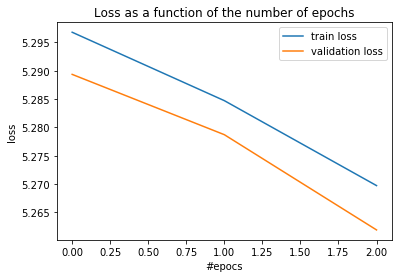

In [11]:
print(train_epoch_losses)
print(validation_epoch_losses)

plt.plot(train_epoch_losses, label="train loss")
plt.plot(validation_epoch_losses, label="validation loss")
plt.xlabel("#epocs")
plt.ylabel("loss")
plt.title("Loss as a function of the number of epochs")
plt.legend()
plt.show()


## Plot Weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

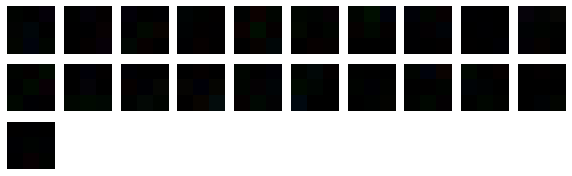

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

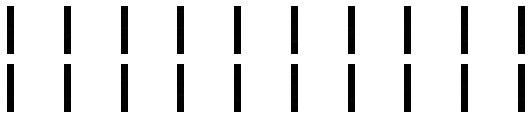

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

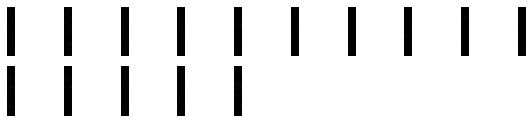

In [12]:
COLUMNS_IN_FIGURE = 10

def plot_weights(model, layer):
    weight_tensor = model.main._modules.get(str(layer)).weight.data

    if not weight_tensor.shape[-1] == 3:
        raise Exception("last dim needs to be 3")
    num_weights = weight_tensor.shape[0]
    num_rows = 1 + num_weights // COLUMNS_IN_FIGURE
    fig = plt.figure(figsize=(COLUMNS_IN_FIGURE, num_rows))
    for i in range(weight_tensor.shape[0]):
        sub = fig.add_subplot(num_rows, COLUMNS_IN_FIGURE, i + 1)
        sub.axis('off')
        sub.imshow(weight_tensor[i])
        sub.set_xticklabels([])
        sub.set_yticklabels([])

    plt.show()


plot_weights(net, 0)
plot_weights(net, 2)
plot_weights(net, 5)